<h1 align="center" style="background-color:#616161;color:white">Next play prediction using Bayesian Inference</h1>

Here we shall apply Bayesian Inference, and specifically a Beta conjugate prior, to determine the liklihood of a user listening
to music in a given time slot.

<h4>Methodology</h4>
* $\theta$ is the probability of someone listening to music in a given Timeslot. This is what we wish to determine.
* Our prior beliefs will be based on analyzing the entire population, and our posterior belief will be to take into account a users personal play history up to the cut-off point for the training data

$p(\theta_{jt} | Y_{jt}) = Beta(\alpha_{jt} + Y_{jt}, \beta_{jt} + N_{jt}-Y_{jt})$ 
for user j, at time slot $t$

* Note: How we determine the prior probability is based on analyzing how many times users played music in that time slot out of the total number of chances they had to listen to music in that time slot. This latter amount has to be estimated from the data in a somewhat crude manner (count up the total number of weeks they listened to music in ANY timeslot ).

<h3 style="background-color:#616161;color:white">0. Setup</h3>

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Input Parameters</div>

In [1]:
PeriodGranularity = 60 # E.g. 15, 30, 60
# Train / Test split
MinsSincePrevPlay = 60   # Best to keep this at 60
newUsers = 10   # Num of randomly selected users to separate out of eval 2

# Root path
root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
#root = "/home/badrul/Documents/github/MusicRecommendation" # BA, Linux

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Import Libraries</div>

In [2]:
# Core
import numpy as np
import pandas as pd
from IPython.core.debugger import Tracer    # Used for debugging
import logging

# File and database management
import csv
import os
import sys
import json
import sqlite3
from pathlib import Path

# Date/Time
import datetime
import time

# Visualization
from ggplot import *                        # Preferred
import matplotlib.pyplot as plt             # Quick
%matplotlib inline

# Data science (comment out if not needed)
#from sklearn.manifold import TSNE

# Misc
import random

#-------------- Custom Libs -----------------#
os.chdir(root)

# Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

# Custom Libs
import coreCode as cc
import lastfmCode as fm

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Declare Functions</div>

In [17]:
# Function definition

def estBetaParams(mu, var):
    a = ((1 - mu) / var - 1 / mu) * mu**2
    b = a * (1 / mu - 1)
    return (a,b)

def getNextPlayProb_Beta(df,Timeslot):
    # Calculate posteriors: a=a+y and b=b+n-y
    playCount = df[df.Timeslot == Timeslot]['PlayCount']
    # Count num of weeks up to this point
    totalWks = len(df.PlayDate.dt.week.unique())
    a = priorDf.loc[timeslot]['a'] + playCount
    b = priorDf.loc[timeslot]['b'] + totalWks-playCount
    mu = a/(a+b)
    print(a,b,mu)
    return mu

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Load settings</div>

In [4]:
settingsDict =  cc.loadSettings()
dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Other setup</div>

<div style="background-color:#white; color:red; font-family: 'Courier New, Monospace;font-weight: bold">(Only need to run this once as stores results in db)</div>

In [27]:
db = sqlite3.connect(dbPath)
c=db.cursor()

# Create tblMainAgg
c=db.cursor()
c.execute('DROP TABLE IF EXISTS tblMainAgg')
SqlStr = 'CREATE TABLE tblMainAgg (UserID integer, PlayDate text, Timeslot text)';

c.execute(SqlStr)
db.commit()

SqlStr ="""INSERT INTO tblMainAgg  SELECT M.UserID, strftime('%d-%m-%Y',PlayedTimestamp) as playDate,
(strftime('%w',PlayedTimestamp)+1) || '-' || (strftime('%H',M.PlayedTimestamp)) || "-" || 
(cast(strftime('%M',M.PlayedTimestamp) / {} +1 as int)) as Timeslot from tblMain as M
Group BY userID,playDate,Timeslot""".format(PeriodGranularity)

c.execute(SqlStr)
db.commit()
db.close()

<h3 style="background-color:#616161;color:white">1. Get train & test data</h3>

10 Test users have been pre-selected in a previous notebook. Here we load up the 10 into a test datast, and the remainder into a training dataset

The test set will be 'new users' and we will evaluate how well we can predict when the user wishes to listen to music as more and more observations come in.



In [5]:
con = sqlite3.connect(dbPath)

# Select the train users
SQLStr="""
SELECT M.UserID, Timeslot, count(*) as PlayCount from tblMainAgg as M 
INNER JOIN tblUsers ON M.UserID = tblUsers.UserID 
WHERE tblUsers.TestUser = 0 GROUP BY M.UserID, Timeslot""".format(PeriodGranularity)

trainDf = pd.read_sql_query(SQLStr, con)

users = trainDf['UserID'].unique()

# Also fetch the total number of weeks each user has played music
sqlStr = "Select userID, count(DISTINCT (strftime('%W',PlayedTimestamp)||strftime('%Y',PlayedTimestamp))) as TotalWks from tblMain group by userID"
wks = pd.read_sql_query(sqlStr, con)
wks.set_index('UserID',inplace=True)

con.close()


In [6]:
trainDf.head()

,UserID,Timeslot,PlayCount
0,47,1-00-1,2
1,47,1-01-1,1
2,47,1-07-1,1
3,47,1-08-1,4
4,47,1-09-1,3


In [7]:
wks.head()

,TotalWks
UserID,
47,64
48,6
49,48
50,82
51,53


Note we are now capturing all song plays, and not just the start of a listening session so the pattern isn't as obvious as before

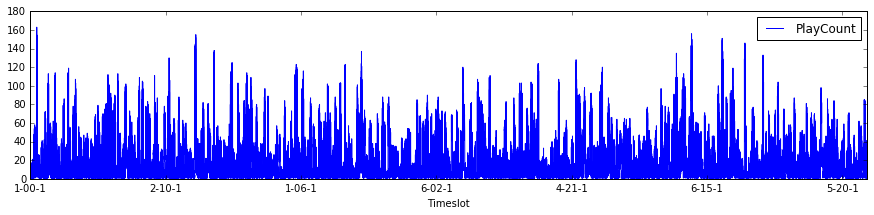

In [8]:
trainDf.plot(x='Timeslot', y='PlayCount',figsize=[15,3])

<h3 style="background-color:#616161;color:white">3. Construct prior probability from train data</h3>

In [9]:
try:
    del trainDf['TotalWks']    # Delete col if it already exists
except KeyError:
    pass

# Calculate probability
trainDf=trainDf.set_index('UserID').join(wks)                      # Bring in total weeks from wks table
trainDf['Prob'] = trainDf['PlayCount'] / trainDf['TotalWks']      # Prob = num of plays in this period / total num of weeks
trainDf.reset_index(inplace=True)

# Calculate the Priors from trainDf. Note: We are taking the mean of the user means here
priorDf= trainDf.groupby('Timeslot')['Prob'].mean().to_frame('mean')  # Calculate the mean of prob for each period
priorDf['var'] = trainDf.groupby('Timeslot')['Prob'].var()           # Calculate the variance of prob for each period
a,b=estBetaParams(priorDf['mean'],priorDf['var'])                # Derive alpha & beta for the Beta dist
priorDf['a']= a                                                 # Store a and b back into priorDf
priorDf['b']= b

In [10]:
trainDf.head()

,UserID,Timeslot,PlayCount,TotalWks,Prob
0,47,1-00-1,2,64,0.031250
1,47,1-01-1,1,64,0.015625
2,47,1-07-1,1,64,0.015625
3,47,1-08-1,4,64,0.062500
4,47,1-09-1,3,64,0.046875


In [11]:
priorDf.head()

,mean,var,a,b
Timeslot,,,,
1-00-1,0.159405,0.018237,1.011787,5.335488
1-01-1,0.151340,0.019412,0.849962,4.766293
1-02-1,0.144524,0.019915,0.752735,4.455631
1-03-1,0.146554,0.020685,0.739609,4.307043
1-04-1,0.143099,0.020076,0.730943,4.376996


<h4 style="background-color:#616161;color:white">Review prior probability</h4>

Let's do a few checks to make sure we've calculated the probability correctly.

Check that the min/max is within 0-1 boundaries

In [12]:
trainDf['Prob'].describe()

count    123695.000000
mean          0.183126
std           0.155814
min           0.004425
25%           0.063158
50%           0.140741
75%           0.259459
max           1.000000
Name: Prob, dtype: float64

Let's do a histogram to see what the distribution looks like

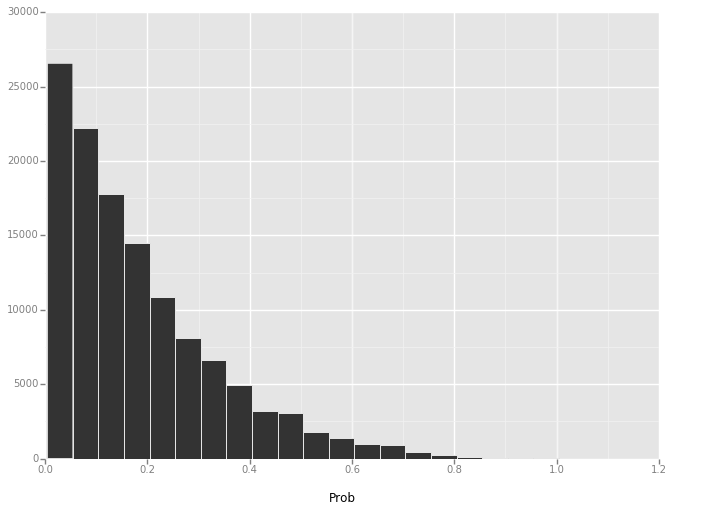

<ggplot: (143997154301)>

In [13]:
ggplot(aes(x='Prob'), data=trainDf) + \
    geom_histogram(binwidth=0.05)

The plot shows that most of the probabilities are very low which is as expected>

More crucially we can plot this distribution for a specific time-period

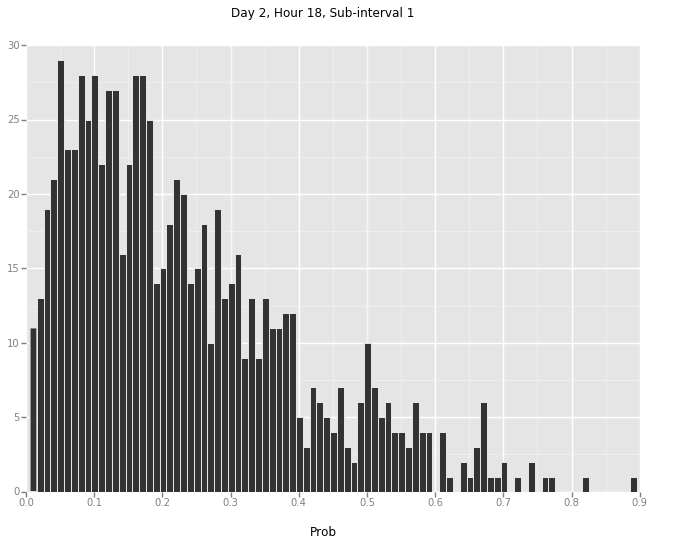

<ggplot: (143997154056)>

In [14]:
Timeslot='2-18-1'
ggplot(aes(x='Prob'), data=trainDf[trainDf.Timeslot==Timeslot]) + \
    geom_histogram(binwidth=0.01) + ggtitle("Day {}, Hour {}, Sub-interval {}".format(Timeslot[0],Timeslot[2:4],Timeslot[5]))

We can also plot the Estimated distribution for this Timeslot based on our Beta pdf

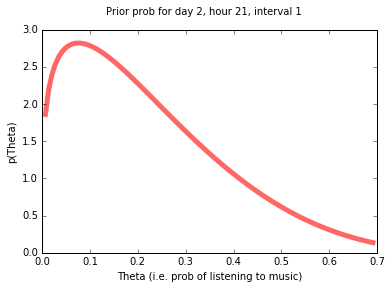

In [103]:
from scipy.stats import beta


p = '2-21-1'
a = priorDf.loc[p]['a']
b = priorDf.loc[p]['b']

# Plot our prior Beta PDF
fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)  # Generate prob distribution
ax.set_xlabel('Theta (i.e. prob of listening to music)')
ax.set_ylabel('p(Theta)')

fig.suptitle('Prior prob for day {}, hour {}, interval {}'.format(p[0],p[2:4],p[5]))
ax.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6)

<h3 style="background-color:#616161;color:white">4. Evaluate model</h3>

We now have a set of priors for every Timeslot, and we have the test user data on which to evaluate our model.
What we wish to do is compare the individual user probability for a time slot, with the prob derived from our Beta distribution.

In [16]:
# Fetch the test data
con = sqlite3.connect(dbPath)

SQLStr="""
SELECT M.UserID, PlayDate, Timeslot, count(*) as PlayCount from tblMainAgg as M 
INNER JOIN tblUsers ON M.UserID = tblUsers.UserID 
WHERE tblUsers.TestUser =1 GROUP BY M.UserID, PlayDate, Timeslot""".format(PeriodGranularity)
testDf = pd.read_sql_query(SQLStr, con)

con.close()
testDf["PlayDate"] = pd.to_datetime(testDf["PlayDate"])
testDf.sort_values(['UserID','PlayDate'], inplace=True)
testDf.reset_index(inplace=True, drop=True)
testDf.head()

,UserID,PlayDate,Timeslot,PlayCount
0,93,2006-07-10,7-18-1,1
1,93,2008-01-06,1-00-1,1
2,93,2008-01-06,1-01-1,1
3,93,2008-01-06,1-02-1,1
4,93,2008-01-06,1-03-1,1


We wish to construct a results table that has the following columns: User,Timeslot,cumulativeCount, TotalWks, actualProb, estProb.

The cumulativeCount will allow us to track how the actual prob and predicted prob change as more observations are seen.

As we haven't kept the time stamp in the dataset we shall just randomize the order of the observations to simulate a user listening over time

In [53]:
# Go through each row of the dataframe
for i in range (0,testDf.shape[0]):
    df =testDf.iloc[0:i]
    timeslot = testDf.iloc[i]['Timeslot']
    userID = testDf.iloc[0]['UserID']
    df=testDf.iloc[0:i]                                      # Extract just rows up to point i
    res = getNextPlayProb_Beta(df[df.UserID == userID],timeslot)   # Filter for the specific user and pass to function
    testDf.loc[(i),'EstProb'] = res
    i+=1

In [52]:
def getNextPlayProb_Beta(df,Timeslot):
    # Calculate posteriors: a=a+y and b=b+n-y
    playCount = df[df.Timeslot == Timeslot]['PlayCount'].sum()
    # Count num of weeks up to this point
    totalWks = len(df.PlayDate.dt.week.unique())
    a = priorDf.loc[timeslot]['a'] + playCount
    b = priorDf.loc[timeslot]['b'] + totalWks-playCount
    mu = a/(a+b)
    return mu

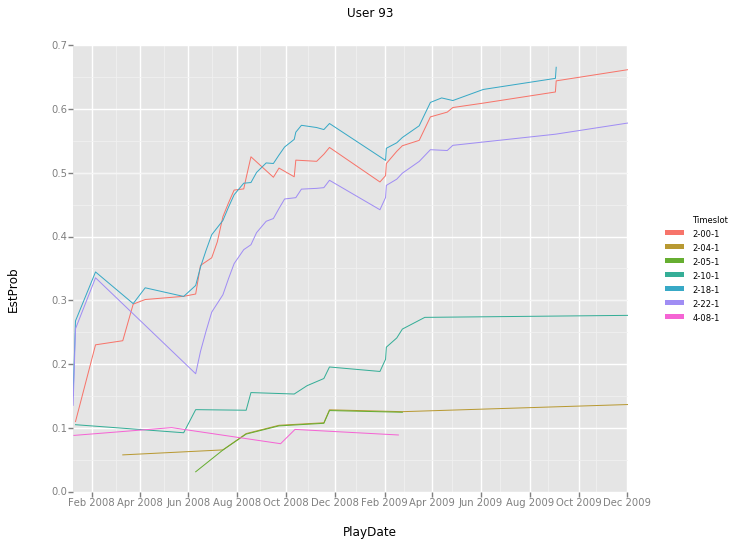

<ggplot: (-9223371892855975722)>

In [102]:
t=['2-00-1','2-05-1','2-10-1','2-18-1','2-22-1','2-04-1','4-08-1']
u=93

df=testDf[(testDf.UserID == u) & (testDf.Timeslot.isin(t))]
ggplot(df, aes(x='PlayDate', y='EstProb',color='Timeslot')) + geom_line()  + ggtitle("User {}".format(u))

In [110]:
testDf[testDf.UserID == u].groupby(['Timeslot'])['PlayCount'].sum()[24:48]

Timeslot
2-00-1    38
2-01-1    37
2-02-1    30
2-03-1    18
2-04-1     8
2-05-1     7
2-06-1     8
2-07-1    11
2-08-1     5
2-09-1     9
2-10-1    16
2-11-1    17
2-12-1    21
2-13-1    23
2-14-1    19
2-15-1    22
2-16-1    28
2-17-1    35
2-18-1    38
2-19-1    39
2-20-1    34
2-21-1    30
2-22-1    33
2-23-1    36
Name: PlayCount, dtype: int64

In [113]:
testDf[(testDf.UserID == u) & (testDf.Timeslot == '2-22-1')]
#testDf[testDf.UserID == u].groupby(['Timeslot'])['PlayCount'].sum().plot(figsize=[15,3])

,index,UserID,PlayDate,Timeslot,PlayCount,EstProb
43,43,93,2008-01-09,2-22-1,1,0.135278
93,93,93,2008-01-12,2-22-1,1,0.255405
111,111,93,2008-02-06,2-22-1,1,0.335259
713,713,93,2008-06-10,2-22-1,1,0.184825
796,796,93,2008-06-16,2-22-1,1,0.219774
887,887,93,2008-06-23,2-22-1,1,0.251850
972,972,93,2008-06-30,2-22-1,1,0.281392
1096,1096,93,2008-07-14,2-22-1,1,0.308691
1178,1178,93,2008-07-21,2-22-1,1,0.333991
1246,1246,93,2008-07-28,2-22-1,1,0.357504
